# Optimization Model for Energy Scheduling (Model 1a)

This notebook runs an optimization model for PV, grid import/export, and flexible load scheduling. Results for each scenario are plotted and saved in a subfolder called `scenario-results`.

In [14]:

# Import packages
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os


## Function: Run Model with Input Data

In [ ]:

def run_model(
    scenario, 
    Lmin_t,
    Lmax_t,
    Pt_PV,
    ct_PV,
    pt,
    Emin,
    max_import_kW,
    max_export_kW,
    tau_imp,
    tau_exp,
    model_prefix="1a"
):
    """
    Runs the optimization model for energy scheduling with PV, grid import/export, and flexible load.
    """

    results_folder = "scenario-results"
    os.makedirs(results_folder, exist_ok=True)

    model = gp.Model("Scenario")
    HOURS = list(range(24))
    lb = 0.0
    ub = float('inf')

    Lt = {t: model.addVar(Lmin_t, Lmax_t, vtype=GRB.CONTINUOUS, name=f'L{t}') for t in HOURS}
    ut = {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name=f's{t}') for t in HOURS}
    ct = {t: model.addVar(lb, ub, vtype=GRB.CONTINUOUS, name=f'c{t}') for t in HOURS}
    gt_imp = {t: model.addVar(lb, max_import_kW, vtype=GRB.CONTINUOUS, name=f'g{t}_imp') for t in HOURS}
    gt_exp = {t: model.addVar(lb, max_export_kW, vtype=GRB.CONTINUOUS, name=f'g{t}_exp') for t in HOURS}

    model.update()

    model.addLConstr(gp.quicksum(Lt[t] for t in HOURS), GRB.GREATER_EQUAL, Emin, name="Daily_minimum")

    for t in HOURS:
        model.addLConstr(ut[t] + ct[t], GRB.EQUAL, Pt_PV[t], name=f'PV_allocation_{t}')
        model.addLConstr(ut[t] + gt_imp[t], GRB.EQUAL, Lt[t] + gt_exp[t], name=f'Energy_balance_{t}')

    model.setObjective(
        gp.quicksum(
            (pt[t] + tau_imp) * gt_imp[t]
            - (pt[t] - tau_exp) * gt_exp[t]
            + ct_PV * Pt_PV[t]
            for t in HOURS
        ),
        GRB.MINIMIZE,
    )

    model.optimize()

    dual_objective = 0.0
    if model.status == GRB.OPTIMAL:
        for c in model.getConstrs():
            if c.Pi != 0:
                dual_objective += c.RHS * c.Pi
        print(f"Optimization {scenario} successful!")
        print("Optimal objective value:", model.ObjVal)
        print("Dual objective value:", dual_objective)
    elif model.status == GRB.INFEASIBLE:
        print("Model is infeasible")
    elif model.status == GRB.UNBOUNDED:
        print("Model is unbounded")
    else:
        print("Optimization ended with status:", model.status)
        
    #
    # Print dual variable values!
    #
    # print("/n/n |constraints|")
    # for c in model.getConstrs():
    #     print(f"{c.ConstrName}: {c.Pi}")

    Lt_values = [Lt[t].X for t in HOURS]
    ut_values = [ut[t].X for t in HOURS]
    ct_values = [ct[t].X for t in HOURS]
    gt_imp_values = [gt_imp[t].X for t in HOURS]
    gt_exp_values = [gt_exp[t].X for t in HOURS]

    # ---------- PLOT 1 ----------
    plt.figure(figsize=(12, 6))
    plt.plot(HOURS, Lt_values, label='Load Consumption (Lt)', marker='o')
    plt.plot(HOURS, ut_values, label='PV not curtailed (ut)', marker='s')
    plt.plot(HOURS, ct_values, label='PV Curtailed (ct)', marker='^')
    plt.plot(HOURS, gt_imp_values, label='Grid Import (gt_imp)', marker='x')
    plt.plot(HOURS, gt_exp_values, label='Grid Export (gt_exp)', marker='D')
    plt.plot(HOURS, Pt_PV, label='PV Production (Pt_PV)', marker='*')
    plt.xlabel('Hour')
    plt.ylabel('Value (kWh)')
    plt.title(f'Scenario {scenario}: All Decision Variable Values Over Time (vs. PV_production)')
    plt.xticks(HOURS)
    plt.legend()
    plt.grid(True)

    plot_filename_1 = os.path.join(results_folder, f"{model_prefix}-scenario-{scenario}-AllDecisionVariables.png")
    plt.savefig(plot_filename_1, bbox_inches='tight')
    plt.show()
    plt.close()

    # ---------- PLOT 2 ----------
    fig, ax1 = plt.subplots(figsize=(12, 6))
    color = 'tab:red'
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Energy Price (DKK/kWh)', color=color)
    ax1.plot(HOURS, pt, color=color, marker='o', label='Energy price(DKK/kWh)')
    ax1.plot(HOURS, np.repeat(tau_imp, 24), color='tab:orange', label='Import tariff (DKK/kWh)')
    ax1.plot(HOURS, np.repeat(tau_exp, 24), color='tab:pink', label='Export tariff (DKK/kWh)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Energy Amount (kWh)', color='tab:blue')
    ax2.plot(HOURS, gt_imp_values, color='tab:blue', marker='x', linestyle='dashed', label='Grid Import(kWh)')
    ax2.plot(HOURS, gt_exp_values, color='tab:green', marker='D', linestyle='dashed', label='Grid Export(kWh)')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Scenario {scenario}: Energy Price vs. Grid Import/Export Over Time')
    fig.tight_layout()
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.xticks(HOURS)

    plot_filename_2 = os.path.join(results_folder, f"{model_prefix}-scenario-{scenario}-EnergyPriceVsGrid.png")
    plt.savefig(plot_filename_2, bbox_inches='tight')
    plt.show()
    plt.close()

    return {
        "Lt": Lt_values,
        "ut": ut_values,
        "ct": ct_values,
        "gt_imp": gt_imp_values,
        "gt_exp": gt_exp_values,
        "objective": model.ObjVal if model.status == GRB.OPTIMAL else None,
        "dual_objective": dual_objective if model.status == GRB.OPTIMAL else None,
    }


## Load Data and Run Scenarios


--- Running Scenario 1: Flat cost structure ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x6cdf857c
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 33 rows and 74 columns
Presolve time: 0.00s
Presolved: 16 rows, 46 columns, 61 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.5000000e+03   1.876877e+03   0.000000e+00      0s
       1    2.9265000e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.926500000e+01
Optimization Scenario 1: Flat cost structure successful!
Optimal objective

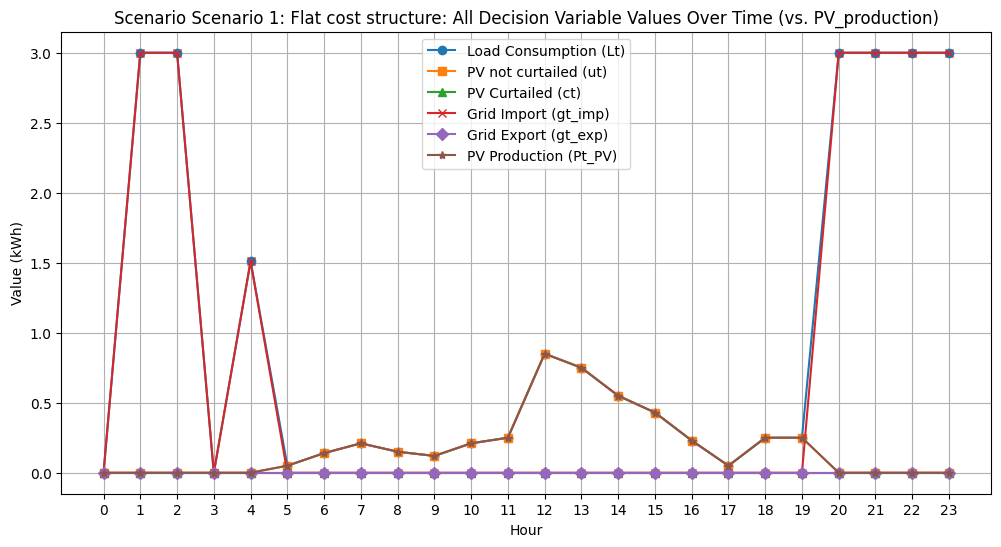

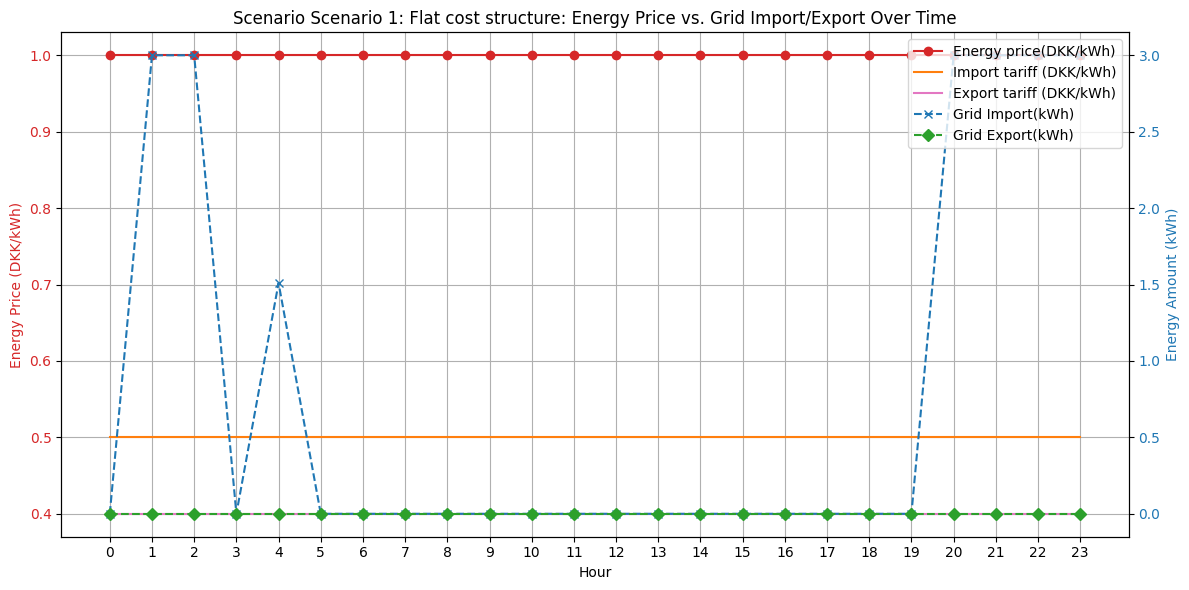


--- Running Scenario 2: High export penalty ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x30c2188d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 33 rows and 66 columns
Presolve time: 0.00s
Presolved: 16 rows, 54 columns, 69 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.8500000e+03   1.001842e+04   0.000000e+00      0s
       9    2.3413000e+01   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.341300000e+01
Optimization Scenario 2: High export penalty successful!
Optimal objective

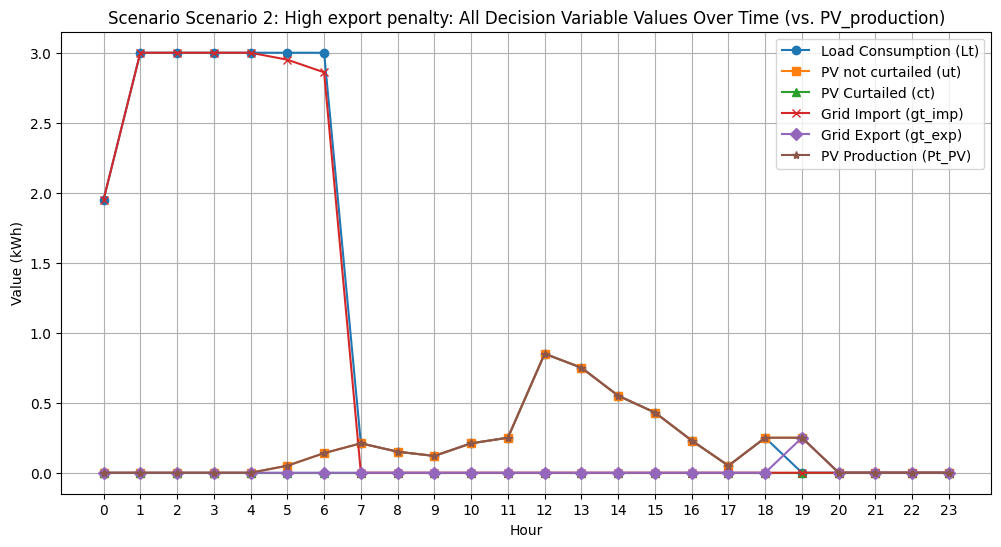

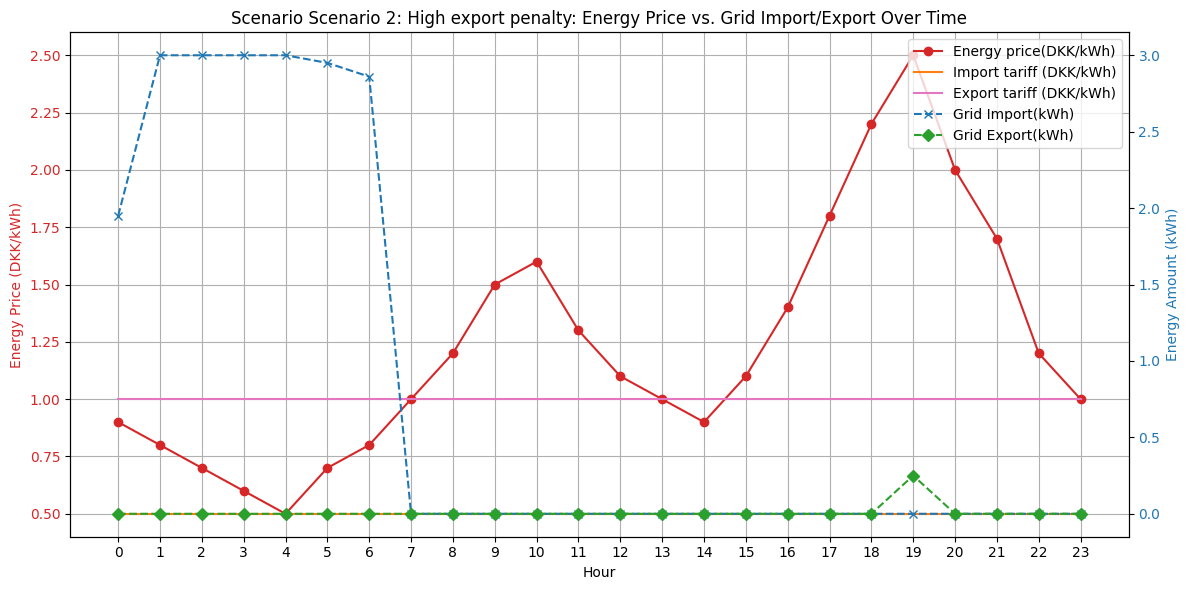


--- Running Scenario 3: Incentivize curtailment ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x059708d6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 39 rows and 85 columns
Presolve time: 0.01s
Presolved: 10 rows, 35 columns, 44 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.1599000e+03   4.998700e+03   0.000000e+00      0s
      13   -1.0971000e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.01 seconds (0.00 work units)
Optimal objective -1.097100000e+01
Optimization Scenario 3: Incentivize curtailment successful!
Optimal 

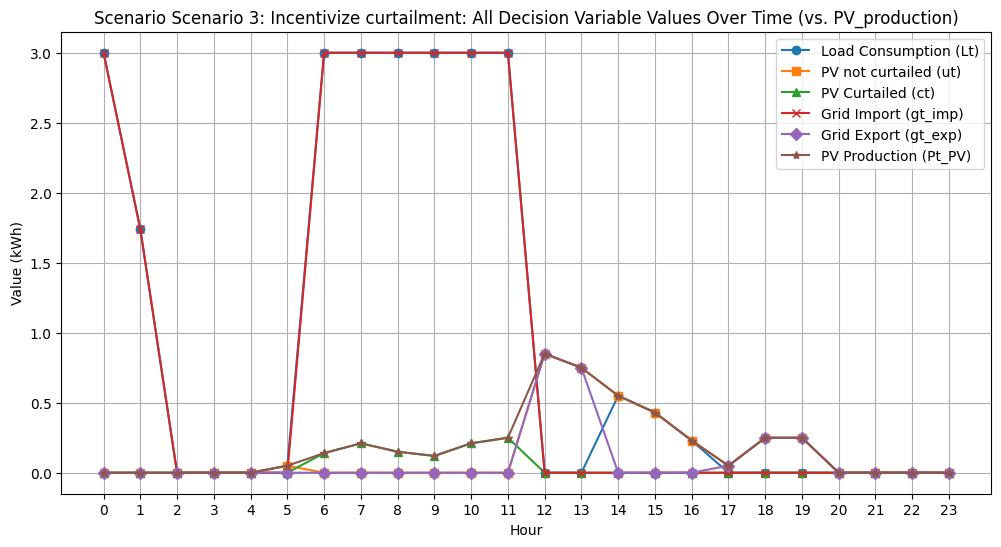

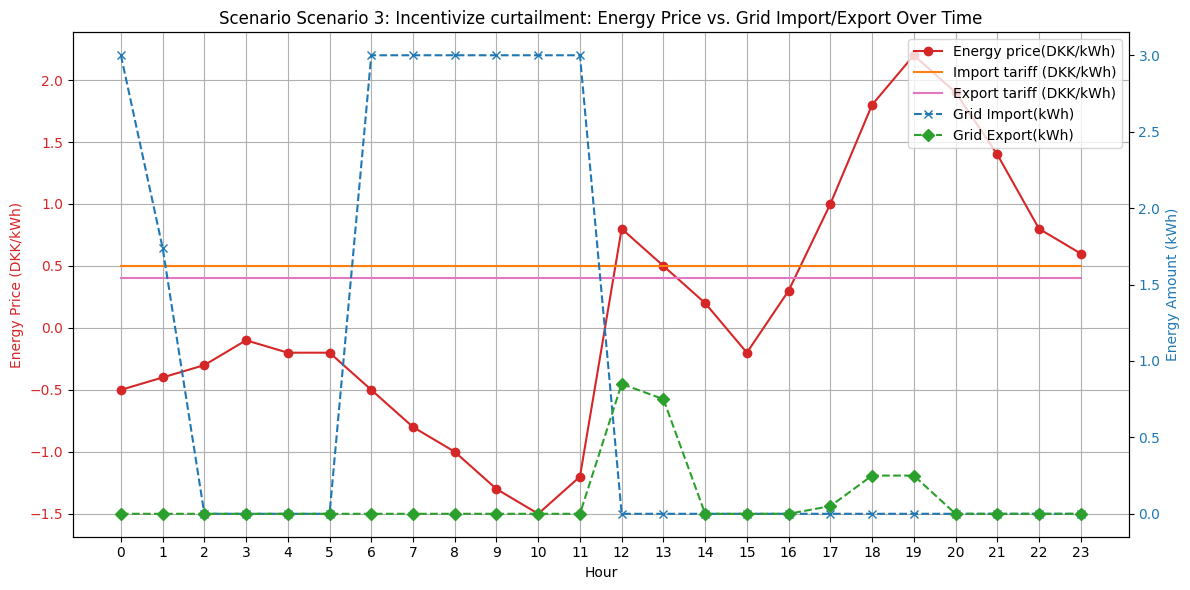


--- Running Scenario 4: No tariffs ---
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-1260P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 120 columns and 168 nonzeros
Model fingerprint: 0x54fd4eae
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-01, 2e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [5e-02, 2e+01]
Presolve removed 48 rows and 105 columns
Presolve time: 0.00s
Presolved: 1 rows, 15 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.5375000e+00   1.200000e+01   0.000000e+00      0s
       1    1.7742500e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.774250000e+01
Optimization Scenario 4: No tariffs successful!
Optimal objective value: 17.7425000

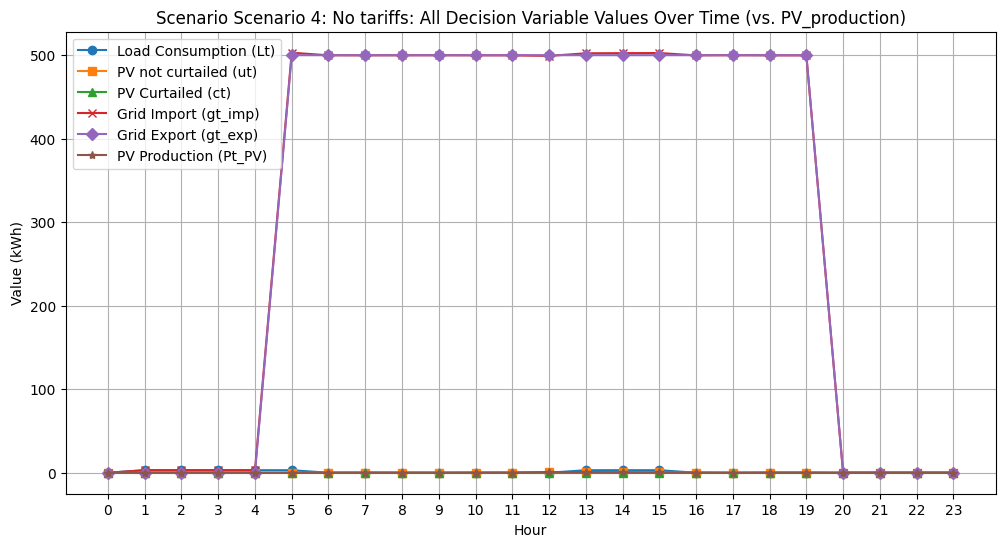

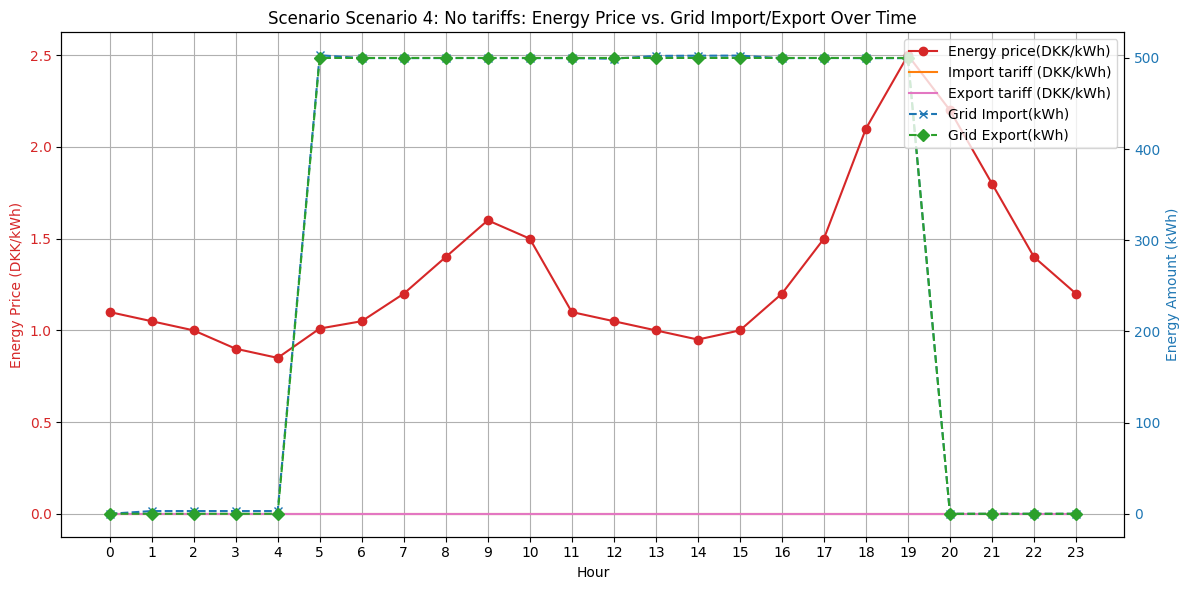

In [16]:

with open('../data/question_1a/DER_production.json', 'r') as file:
    der_production = json.load(file)
with open('../data/question_1a/appliance_params.json', 'r') as file:
    appl_params = json.load(file)
with open('../data/question_1a/usage_preference.json', 'r') as file:
    usage_preference = json.load(file)
with open('../data/scenarios.json', 'r') as file:
    scenarios = json.load(file)

results_summary = []

for i, scenario in enumerate(scenarios):
    print(f"\n--- Running {scenario['scenario']} ---")
    result = run_model(
        scenario=scenario["scenario"],
        Lmin_t=0.0,
        Lmax_t=appl_params["load"][0]["max_load_kWh_per_hour"],
        Pt_PV=der_production[0]["hourly_profile_ratio"],
        ct_PV=0,
        pt=scenario["energy_price_DKK_per_kWh"],
        Emin=usage_preference[0]["load_preferences"][0]["min_total_energy_per_day_hour_equivalent"] 
             * appl_params["load"][0]["max_load_kWh_per_hour"],
        max_import_kW=scenario["max_import_kW"],
        max_export_kW=scenario["max_export_kW"],
        tau_imp=scenario["import_tariff_DKK/kWh"],
        tau_exp=scenario["export_tariff_DKK/kWh"],
        model_prefix="1a"
    )

    results_summary.append({
        "Scenario": scenario["scenario"],
        "Primal Objective": result["objective"],
        "Dual Objective": result["dual_objective"]
    })


## Summary of Optimization Results

In [17]:

if not results_summary:
    print("No results found. Please run the scenarios first.")
else:
    df_results = pd.DataFrame(results_summary)
    display(df_results)


,Scenario,Primal Objective,Dual Objective
0,Scenario 1: Flat cost structure,29.2650,29.2650
1,Scenario 2: High export penalty,23.4130,27.3130
2,Scenario 3: Incentivize curtailment,-10.9710,1.0290
3,Scenario 4: No tariffs,17.7425,19.6625
